# Pecipitation and the ENSO index
### Zak M

#### Importing dependencies

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

#### Loading precip data

In [2]:
path = '/scratch/zmanthos/thesis/'
file = 'gpcp.lat25-55N.lon130-50W.nc'
files = path+file
data = xr.open_dataset(files,decode_times=True,decode_cf=True)
print(data['time'])
#print(data)

<xarray.DataArray 'time' (time: 8038)>
array(['1997-01-01T00:00:00.000000000', '1997-01-02T00:00:00.000000000',
       '1997-01-03T00:00:00.000000000', ..., '2018-12-29T00:00:00.000000000',
       '2018-12-30T00:00:00.000000000', '2018-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1997-01-01 1997-01-02 ... 2018-12-31
Attributes:
    standard_name:  time
    long_name:      time
    bounds:         time_bnds
    axis:           T


#### Loading the ENSO Nino 3.4 index
###### This index was created from weekly OISSTv2 data. It uses only the data within the time period and is projected to a daily timeseries using a 'nearest' method

In [3]:
path1 = '/homes/zmanthos/thesis/index/'
file1 = 'enso.nin34.97-18.nc'
enso = xr.open_dataset(path1+file1,decode_times=True,decode_cf=True)
print(enso)

<xarray.Dataset>
Dimensions:  (time: 8038)
Coordinates:
  * time     (time) datetime64[ns] 1997-01-01 1997-01-02 ... 2018-12-31
Data variables:
    enso     (time) float64 ...
Attributes:
    Title:    Nino 3.4 Standardized index
    About:    Area avg of weekly SST anoms Center of week starts on Jan 5th 1997
    Area:     Nino 3.4 area http://www.bom.gov.au/climate/ahead/about-ENSO-ou...
    Sigma:    1.093002
    By:       Zak Manthos


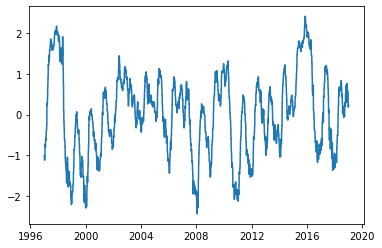

In [4]:
plt.plot(enso['time'],enso['enso'])

#### Creating the Different Bins of the index

In [5]:
positive=enso['enso'].where(enso['enso']>=1).dropna(dim='time')
negative=enso['enso'].where(enso['enso']<=-1).dropna(dim='time')
neutral=enso['enso'].where(np.logical_and(enso['enso']>-1,enso['enso']<1)).dropna(dim='time')
print(len(positive['time']),len(negative['time']),len(neutral['time']))


1225 1443 5370


#### Computing Anomalies

In [6]:
clima = data.groupby('time.dayofyear').mean()
anoms = data.groupby('time.dayofyear') - clima;

#### Cutting and averaging data for each bin

In [7]:
negs = data.sel(time=negative.dropna(dim='time')['time']).mean(dim='time')
# can't figure out why this wasn't working

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

#### Work-around 

In [8]:
pos = anoms.where(anoms['time'].isin(positive['time'].values)).dropna(dim='time',thresh=100)
neg = anoms.where(anoms['time'].isin(negative['time'].values)).dropna(dim='time',thresh=100)
neu = anoms.where(anoms['time'].isin(neutral['time'].values)).dropna(dim='time',thresh=100)
print(len(pos['time']),len(neg['time']),len(neu['time']))

1225 1443 5370


#### Justification for the threshold

In [9]:
tts = 0;
for x in range(0,len(positive['time'])):
    pt1 = positive['time'][x]
    pt2 = pos['time'][x]
    truth = (pt1==pt2)
    if truth == True:
        tts+=1;
    else:
        print('\n FALSE: ', pt1.values,pt2.values,'\n')
pos = pos.mean(dim='time')
print('Positive date truths:',tts,' \n')
tts = 0;
for x in range(0,len(negative['time'])):
    pt1 = negative['time'][x]
    pt2 = neg['time'][x]
    truth = (pt1==pt2)
    if truth == True:
        tts+=1;
    else:
        print('\n FALSE: ', pt1.values,pt2.values,'\n')
neg = neg.mean(dim='time')
print('Negative date truths:',tts,' \n')
tts = 0;
for x in range(0,len(neutral['time'])):
    pt1 = neutral['time'][x]
    pt2 = neu['time'][x]
    truth = (pt1==pt2)
    if truth == True:
        tts+=1;
    else:
        print('\n FALSE: ', pt1.values,pt2.values,'\n')
neu = neu.mean(dim='time')
print('Neutral date truths:',tts,' \n')

Positive date truths: 1225  

Negative date truths: 1443  

Neutral date truths: 5370  



### Graphing of Composites

Setting font color

In [22]:
COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

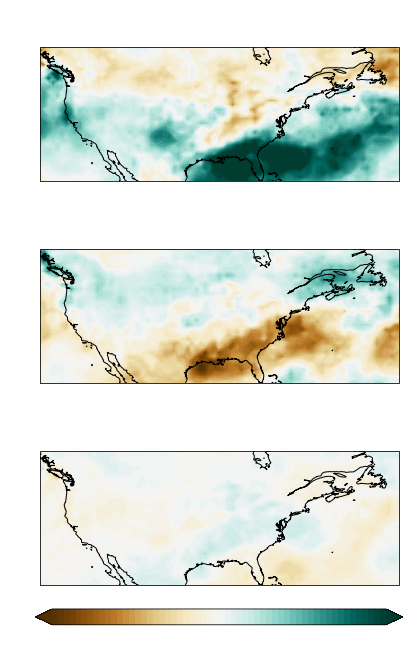

In [24]:
precip_bins = [pos,neg,neu];
lengths = [len(positive),len(negative),len(neutral)]
labels=['El Nino','La Nina', 'Neutral']
levels=np.linspace(-0.7,0.7,57)

fig, axs = plt.subplots(nrows=3,ncols=1,subplot_kw={'projection': ccrs.PlateCarree()},figsize=(8.5,11))

axs=axs.flatten()

n=0;
for enso in enumerate(precip_bins):
        data=precip_bins[n]['precip']
        cs=axs[n].contourf(precip_bins[n]['longitude'],precip_bins[n]['latitude'],data,levels=levels,
                          transform = ccrs.PlateCarree(),
                          cmap='BrBG',extend='both')
        

        axs[n].set_xticks(np.arange(-130,-49,10), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[n].xaxis.set_major_formatter(lon_formatter)

        axs[n].set_yticks(np.arange(25,56,10), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[n].yaxis.set_major_formatter(lat_formatter)

        axs[n].set_title(labels[n]+' ('+str(lengths[n])+')')
        axs[n].coastlines()
        n+=1;

fig.subplots_adjust(bottom=0.25, top=0.93, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.5)

cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.02])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='mm/day')
plt.suptitle('Composites: Precipitation Anomalies & ENSO index',weight='bold')
fig.savefig('enso.compos.png')